In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [29]:
theta=np.array([  1.688 ,   6.188 ,  10.688 ,  15.188 ,  19.688 ,  24.188 ,  28.688 ,  33.188 ,  37.688 ,  42.188,
                46.688 ,  51.188 ,  55.688 ,  60.188 ,  64.688 ,  69.188 ,  73.688 ,  78.188 ,  82.688 ,  87.188,
                91.688 ,  96.188 , 100.688 , 105.188 , 109.688 , 114.188 , 118.688 , 123.188 , 127.688 , 132.188,
                136.688 , 141.188 , 145.687 , 150.188 , 154.688 , 159.188 , 163.688 , 168.187 , 172.687 , 177.187,
                181.687 , 186.187 , 190.687 , 195.187 , 199.687 , 204.187 , 208.687 , 213.187 , 217.687 , 222.187,
                226.687 , 231.187 , 235.687 , 240.187 , 244.687 , 249.187 , 253.687 , 258.187 , 262.687 , 267.187,
                271.687 , 276.187 , 280.687 , 285.187 , 289.687 , 294.187 , 298.687 , 303.187 , 307.687 , 312.187,
                316.687 , 321.187 , 325.687 , 330.187 , 334.687 , 339.187 , 343.687 , 348.187 , 352.687 , 357.187, 367.688])

#theta=theta-90.
#theta=theta/360*np.pi*2

#normal grid lat north
r=np.array([53.109 ,  55.172 ,  57.234 ,  59.297 ,  61.359 ,  63.422 ,  65.484 ,  66.783 ,  67.826 ,  68.870,
            69.913 ,  70.957 ,  72.000 ,  73.044 ,  74.087 ,  75.130 ,  76.174 ,  77.217 ,  78.261 ,  79.304,
            80.348 ,  81.391 ,  82.435 ,  83.478 ,  84.522 ,  85.565 ,  86.609 ,  87.652 ,  88.696 ,  89.739])
#r=90-r


In [18]:
theta_lin = np.linspace(1.688, 367.688, 81)

In [19]:
theta_lin

array([  1.688,   6.263,  10.838,  15.413,  19.988,  24.563,  29.138,
        33.713,  38.288,  42.863,  47.438,  52.013,  56.588,  61.163,
        65.738,  70.313,  74.888,  79.463,  84.038,  88.613,  93.188,
        97.763, 102.338, 106.913, 111.488, 116.063, 120.638, 125.213,
       129.788, 134.363, 138.938, 143.513, 148.088, 152.663, 157.238,
       161.813, 166.388, 170.963, 175.538, 180.113, 184.688, 189.263,
       193.838, 198.413, 202.988, 207.563, 212.138, 216.713, 221.288,
       225.863, 230.438, 235.013, 239.588, 244.163, 248.738, 253.313,
       257.888, 262.463, 267.038, 271.613, 276.188, 280.763, 285.338,
       289.913, 294.488, 299.063, 303.638, 308.213, 312.788, 317.363,
       321.938, 326.513, 331.088, 335.663, 340.238, 344.813, 349.388,
       353.963, 358.538, 363.113, 367.688])

In [20]:
theta

array([  1.688,   6.188,  10.688,  15.188,  19.688,  24.188,  28.688,
        33.188,  37.688,  42.188,  46.688,  51.188,  55.688,  60.188,
        64.688,  69.188,  73.688,  78.188,  82.688,  87.188,  91.688,
        96.188, 100.688, 105.188, 109.688, 114.188, 118.688, 123.188,
       127.688, 132.188, 136.688, 141.188, 145.687, 150.188, 154.688,
       159.188, 163.688, 168.187, 172.687, 177.187, 181.687, 186.187,
       190.687, 195.187, 199.687, 204.187, 208.687, 213.187, 217.687,
       222.187, 226.687, 231.187, 235.687, 240.187, 244.687, 249.187,
       253.687, 258.187, 262.687, 267.187, 271.687, 276.187, 280.687,
       285.187, 289.687, 294.187, 298.687, 303.187, 307.687, 312.187,
       316.687, 321.187, 325.687, 330.187, 334.687, 339.187, 343.687,
       348.187, 352.687, 357.187, 367.688])

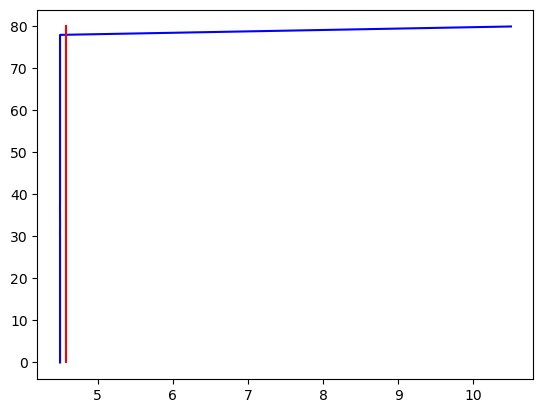

In [24]:
x = np.arange(81)
plt.plot(np.gradient(theta), x, 'b')
plt.plot(np.gradient(theta_lin), x, 'r')

In [30]:
np.gradient(theta)

array([ 4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,
        4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,
        4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,
        4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,
        4.5   ,  4.5   ,  4.5   ,  4.4995,  4.5   ,  4.5005,  4.5   ,
        4.5   ,  4.4995,  4.4995,  4.5   ,  4.5   ,  4.5   ,  4.5   ,
        4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,
        4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,
        4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,
        4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,
        4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,  4.5   ,
        4.5   ,  4.5   ,  7.5005, 10.501 ])

In [31]:
np.gradient(theta_lin)

array([4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575,
       4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575,
       4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575,
       4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575,
       4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575,
       4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575,
       4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575,
       4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575,
       4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575, 4.575])

In [32]:
r

array([53.109, 55.172, 57.234, 59.297, 61.359, 63.422, 65.484, 66.783,
       67.826, 68.87 , 69.913, 70.957, 72.   , 73.044, 74.087, 75.13 ,
       76.174, 77.217, 78.261, 79.304, 80.348, 81.391, 82.435, 83.478,
       84.522, 85.565, 86.609, 87.652, 88.696, 89.739])

In [33]:
r_lin = np.linspace(53.109,89.739,30)
r_lin

array([53.109     , 54.37210345, 55.6352069 , 56.89831034, 58.16141379,
       59.42451724, 60.68762069, 61.95072414, 63.21382759, 64.47693103,
       65.74003448, 67.00313793, 68.26624138, 69.52934483, 70.79244828,
       72.05555172, 73.31865517, 74.58175862, 75.84486207, 77.10796552,
       78.37106897, 79.63417241, 80.89727586, 82.16037931, 83.42348276,
       84.68658621, 85.94968966, 87.2127931 , 88.47589655, 89.739     ])

In [34]:
np.gradient(r)

array([2.063 , 2.0625, 2.0625, 2.0625, 2.0625, 2.0625, 1.6805, 1.171 ,
       1.0435, 1.0435, 1.0435, 1.0435, 1.0435, 1.0435, 1.043 , 1.0435,
       1.0435, 1.0435, 1.0435, 1.0435, 1.0435, 1.0435, 1.0435, 1.0435,
       1.0435, 1.0435, 1.0435, 1.0435, 1.0435, 1.043 ])

In [35]:
np.gradient(r_lin)

array([1.26310345, 1.26310345, 1.26310345, 1.26310345, 1.26310345,
       1.26310345, 1.26310345, 1.26310345, 1.26310345, 1.26310345,
       1.26310345, 1.26310345, 1.26310345, 1.26310345, 1.26310345,
       1.26310345, 1.26310345, 1.26310345, 1.26310345, 1.26310345,
       1.26310345, 1.26310345, 1.26310345, 1.26310345, 1.26310345,
       1.26310345, 1.26310345, 1.26310345, 1.26310345, 1.26310345])